# pipline for A Stage

A STAGE

SEER*Stat Name: SEER historic stage A

Field Description: Derived from Collaborative Stage (CS) for 2004+ and Extent of Disease (EOD) from 1973-2003. It is a simplified version of stage: in situ, localized, regional, distant, & unknown. Over time several different EOD schemes have been used. Thus caution should be used when doing trend analysis. For more information including sites and years for which it isn't calculated, see http://seer.cancer.gov/seerstat/variables/seer/lrd-stage.

1

Regional — A neoplasm that has extended 1) beyond the limits of the organ of origin
directly into surrounding organs or tissues; 2) into regional lymph nodes by way of the
lymphatic system; or 3) by a combination of extension and regional lymph nodes.

2

Distant — A neoplasm that has spread to parts of the body remote from the primary
tumor either by direct extension or by discontinuous metastasis (e.g., implantation or
seeding) to distant organs, issues, or via the lymphatic system to distant lymph nodes.

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
# grid search k value for SMOTE oversampling for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import datasets, metrics, model_selection#, svm
import warnings

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
%matplotlib inline

In [65]:
from cancer_func import cancer_encode
from cancer_func import cancer_features_select
from cancer_func import cancer_encoder
from cancer_func import cancer_features_selector
from cancer_func import report, cross_validation_report
from cancer_func import cancer_encode_without_ms

ImportError: cannot import name 'cross_validation_report' from 'cancer_func' (C:\Users\yotam\Desktop\breast_cancer_classification\cancer_func.py)

In [32]:
df = pd.read_csv('Breast_Cancer.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

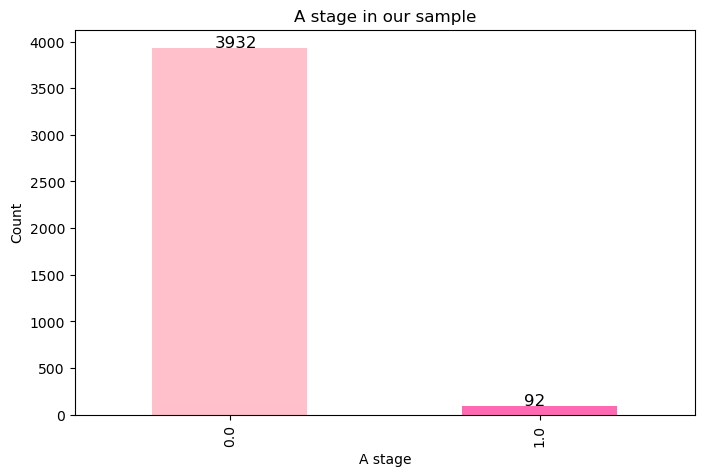

In [77]:
# Set the pinkish colors
colors = ['#FFC0CB', '#FF69B4', '#FF1493']  # Pinkish colors

# Group by 'Grade' and 'Race' and count the rows, specifying the desired order
grouped_df = df.groupby(['A Stage'])['Age'].count()

# Calculate the relative percentages within each grade
#relative_percentages = grouped_df.apply(lambda x: 100 * x / x.sum(), axis=1)


# Plot the unstacked bar graph
ax = grouped_df.plot.bar(color=colors)

# Set the style and labels for the plot
plt.rcParams['figure.figsize'] = (8, 5)  # Adjust the figure size as desired
plt.xlabel('A stage')
plt.ylabel('Count')
plt.title('A stage in our sample')

# Rotate the x-axis labels
#plt.xticks(rotation=45)
for index,data in enumerate(df.groupby(['A Stage'])['6th Stage'].count()):
    ax.text(x=index-0.05 , y =data+10 , s=f"{round(data)}" , fontdict=dict(fontsize=12))

plt.show()

# starting the pipline

In [33]:
def f_new(y_true, y_pred):
    precision = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = 0.8+ f1_score(y_true, y_pred)
        return answer
    else:
        return recall


In [34]:
def f_new2(y_true, y_pred):
    precision = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = recall+ precision
        return answer
    else:
        return recall


In [35]:
#trying to mage my own scorer
from sklearn.metrics import make_scorer, f1_score, recall_score

def f1_recall_avg(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    avg = (f1 + 0.2*recall) / 1.2
    return avg

scorer_f1_recall = make_scorer(f1_recall_avg)

new pipline

In [36]:
df = pd.read_csv('Breast_Cancer.csv')
df = cancer_encode_without_ms(df)
#df = cancer_encode(df)
df = cancer_features_select(df)
X = df.drop(['A Stage'], axis=1, inplace=False) #sould be without  
y = df['A Stage']

In [44]:
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
logistic = LogisticRegression(max_iter=100000) #צריך להגדיר את המודל 
#log_steps = [("encoder",encoder),("selector",selector),("scaler", scaler), ("over", over), ("logistic", logistic)]
log_steps = [("scaler", scaler), ("over", over), ("logistic", logistic)]

pipe_log = Pipeline(steps=log_steps)

param_grid_log = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "logistic__C": [1,4],
    "logistic__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}


In [30]:
search = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(f1_recall_avg))
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
log_estimator = search.best_estimator_

Best parameter (CV score=0.426):
{'logistic__C': 1, 'logistic__class_weight': {0: 1, 1: 1}, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.3}


In [8]:
search_new = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(f_new))
search_new.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new.best_score_)
print(search_new.best_params_)
log_estimator_new = search_new.best_estimator_

Best parameter (CV score=1.121):
{'logistic__C': 4, 'logistic__class_weight': {0: 1, 1: 2}, 'over__k_neighbors': 7, 'over__sampling_strategy': 0.2}


In [45]:
search_new2 = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(f_new2))
search_new2.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new2.best_score_)
print(search_new2.best_params_)
log_estimator_new2 = search_new2.best_estimator_

Best parameter (CV score=1.302):
{'logistic__C': 4, 'logistic__class_weight': {0: 1, 1: 10}, 'over__k_neighbors': 8, 'over__sampling_strategy': 0.2}


In [46]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator_new2, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1, with new f :  %.3f' % mean(scores_log['test_f1']))
print('Mean recall, with new f : %.3f' % mean(scores_log['test_recall']))
print('Mean precision, with new f : %.3f' % mean(scores_log['test_precision']))

Mean f1, with new f :  0.296
Mean recall, with new f : 0.978
Mean precision, with new f : 0.175


In [50]:
df.groupby(['A Stage'])['A Stage'].count()[1]

92

In [64]:
cross_validation_report(df,'A Stage',scores_log)

Mean f1:  0.296
Mean recall: 0.978
Mean precision: 0.175
cross_validation confusion matrix
     0       1
0  3507    425
1   2       90


In [63]:
def cross_validation_report(df,binary_target,cv_scores):
    print('Mean f1:  %.3f' % mean(cv_scores['test_f1']))
    print('Mean recall: %.3f' % mean(cv_scores['test_recall']))
    print('Mean precision: %.3f' % mean(cv_scores['test_precision']))
    rec = mean(cv_scores['test_recall'])
    pre = mean(cv_scores['test_precision'])
    total_p = df.groupby([binary_target])[binary_target].count()[1]
    total_n = df.groupby([binary_target])[binary_target].count()[0]
    TP = rec*total_p
    FN = (1-rec)*total_p
    FP = ((1-pre)/pre)*TP
    TN = total_n - FP
    print("cross_validation confusion matrix")
    print("     0       1")
    print("0 ",round(TN), "  ", round(FP))
    print("1  ",round(FN), "     ", round(TP))

    
    

In [62]:
rec = mean(scores_log['test_recall'])
pre = mean(scores_log['test_precision'])
total_p = df.groupby(['A Stage'])['A Stage'].count()[1]
total_n = df.groupby(['A Stage'])['A Stage'].count()[0]
TP = rec*total_p
FN = (1-rec)*total_p
FP = ((1-pre)/pre)*TP
TN = total_n - FP
print("cross_validation confusion matrix")
print("     0       1")
print("0 ",round(TN), "  ", round(FP))
print("1  ",round(FN), "     ", round(TP))


cross_validation confusion matrix
     0       1
0  3507    425
1   2       90


# evaluate pipeline


In [31]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1, with 1.2 recall :  %.3f' % mean(scores_log['test_f1']))
print('Mean recall, with 1.2 recall : %.3f' % mean(scores_log['test_recall']))
print('Mean precision, with 1.2 recall : %.3f' % mean(scores_log['test_precision']))

Mean f1, with 1.2 recall :  0.311
Mean recall, with 1.2 recall : 0.871
Mean precision, with 1.2 recall : 0.190


In [9]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator_new, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1, with new f :  %.3f' % mean(scores_log['test_f1']))
print('Mean recall, with new f : %.3f' % mean(scores_log['test_recall']))
print('Mean precision, with new f : %.3f' % mean(scores_log['test_precision']))

Mean f1, with new f :  0.303
Mean recall, with new f : 0.896
Mean precision, with new f : 0.182


In [12]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores_log['test_f1']))
print('Mean recall: %.3f' % mean(scores_log['test_recall']))
print('Mean precision: %.3f' % mean(scores_log['test_precision']))


Mean f1:  0.308
Mean recall: 0.864
Mean precision: 0.188


(0.0, 1.1)

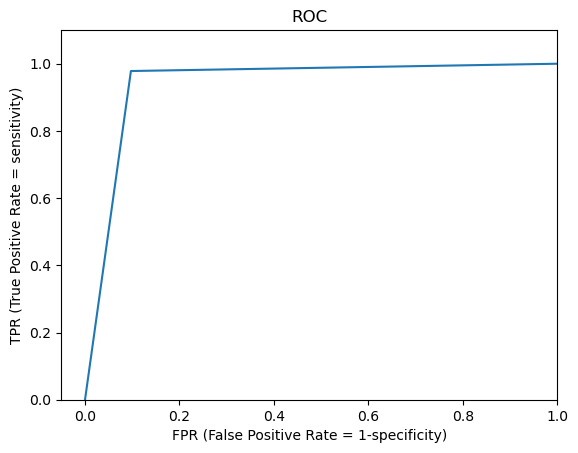

In [51]:
fpr, tpr, thresholds = roc_curve(y, log_estimator_new.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

(0.0, 1.1)

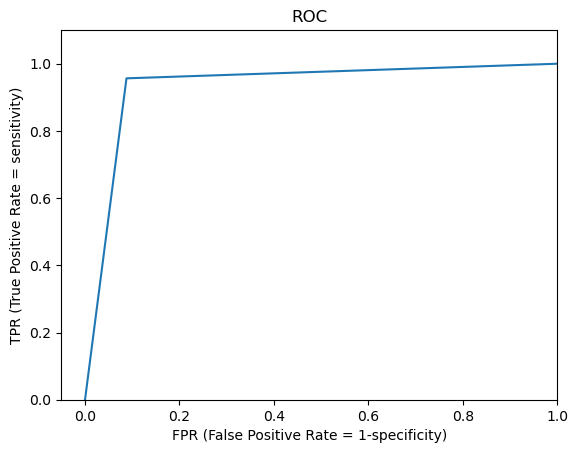

In [10]:
fpr, tpr, thresholds = roc_curve(y, log_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [41]:
#res[res.TPR==1]

In [11]:
print("with f1_recall scorer:")
print(report(search, X, y))

with f1_recall scorer:
accuracy: 0.913

      0.0  1.0
0.0  3587  345
1.0     4   88

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      3932
         1.0       0.20      0.96      0.34        92

    accuracy                           0.91      4024
   macro avg       0.60      0.93      0.64      4024
weighted avg       0.98      0.91      0.94      4024



In [14]:
print("with f1 scorer:")
print(report(search, X, y))

with f1 scorer:
accuracy: 0.911

      0.0  1.0
0.0  3581  351
1.0     7   85

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      3932
         1.0       0.19      0.92      0.32        92

    accuracy                           0.91      4024
   macro avg       0.60      0.92      0.64      4024
weighted avg       0.98      0.91      0.94      4024



# random forest

new

In [52]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}



In [53]:

search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(f_new))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_
#לא ברור לי איך אני יודע שהוא לא עשה הערכה גם על הנתונים שהוא המציא

Best parameter (CV score=1.111):
{'over__k_neighbors': 8, 'over__sampling_strategy': 0.2, 'rf__class_weight': {0: 1, 1: 2}, 'rf__max_depth': 6, 'rf__min_samples_leaf': 10}


In [54]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean recall: %.3f' % mean(scores['test_precision']))

Mean f1:  0.302
Mean recall: 0.854
Mean recall: 0.184


(0.0, 1.1)

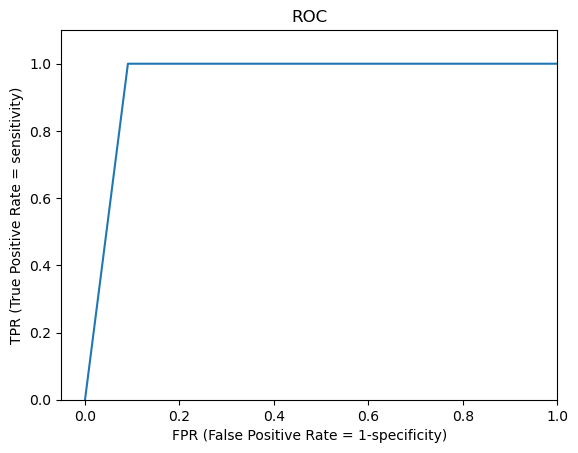

In [55]:
fpr, tpr, thresholds = roc_curve(y, rf_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

old

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}


In [14]:

search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(f1_recall_avg))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_
#לא ברור לי איך אני יודע שהוא לא עשה הערכה גם על הנתונים שהוא המציא

Best parameter (CV score=0.426):
{'over__k_neighbors': 6, 'over__sampling_strategy': 0.1, 'rf__class_weight': {0: 1, 1: 2}, 'rf__max_depth': 6, 'rf__min_samples_leaf': 10}


In [66]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))


Mean f1:  0.333
Mean recall: 0.680


when scorer is 1*f1+0.1*recall

In [38]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean recall: %.3f' % mean(scores['test_precision']))


Mean f1:  0.297
Mean recall: 0.882


when scorer is 1*f1+0.2*recall

In [15]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean recall: %.3f' % mean(scores['test_precision']))


Mean f1:  0.340
Mean recall: 0.647
Mean recall: 0.233


In [18]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores_rf = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores_rf['test_f1']))
print('Mean recall: %.3f' % mean(scores_rf['test_recall']))
print('Mean recall: %.3f' % mean(scores_rf['test_precision']))

Mean f1:  0.328
Mean recall: 0.723
Mean recall: 0.213


(0.0, 1.1)

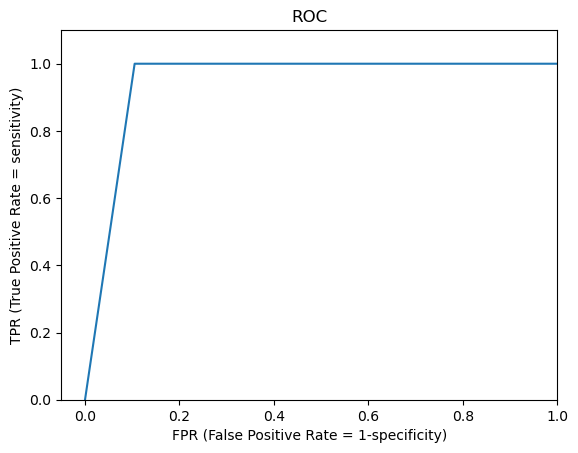

In [40]:
fpr, tpr, thresholds = roc_curve(y, rf_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

(0.0, 1.1)

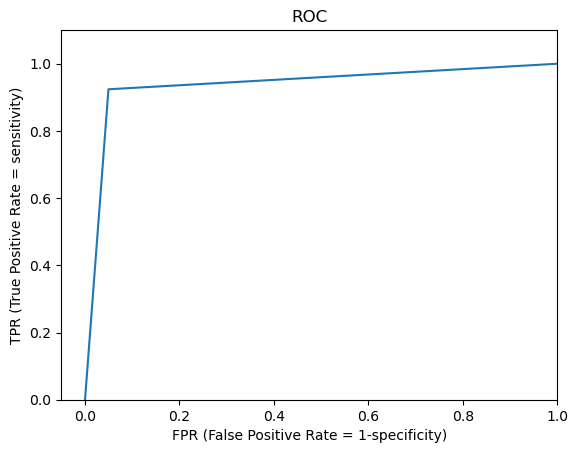

In [16]:
fpr, tpr, thresholds = roc_curve(y, rf_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [15]:
print("with f1 scorer:")
print(report(search, X, y))

with f1 scorer:
accuracy: 0.958

      0.0  1.0
0.0  3779  153
1.0    14   78

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      3932
         1.0       0.34      0.85      0.48        92

    accuracy                           0.96      4024
   macro avg       0.67      0.90      0.73      4024
weighted avg       0.98      0.96      0.97      4024



In [27]:
print("with f1_recall scorer:")
print(report(search_rf, X, y))

with f1_recall scorer:
accuracy: 0.889

      0.0  1.0
0.0  3485  447
1.0     0   92

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      3932
         1.0       0.17      1.00      0.29        92

    accuracy                           0.89      4024
   macro avg       0.59      0.94      0.62      4024
weighted avg       0.98      0.89      0.92      4024



In [42]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 0.63
T Stage  17.43
N Stage 20.79
6th Stage 37.11
Grade 1.22
Tumor Size 3.87
Estrogen Status 0.43
Progesterone Status 0.54
Regional Node Examined 2.22
Reginol Node Positive 10.38
Race_Black 0.0
Race_Other 0.02
Race_White 0.15
Regional_Node_pos_% 5.21


In [17]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 1.38
T Stage  14.26
N Stage 10.96
6th Stage 35.42
Grade 1.71
Tumor Size 2.23
Estrogen Status 0.23
Progesterone Status 0.32
Regional Node Examined 2.31
Reginol Node Positive 8.29
Race_Black 0.19
Race_Other 0.1
Race_White 0.4
6th Stage_IIA 0.44
6th Stage_IIB 0.46
6th Stage_IIIA 0.77
6th Stage_IIIB 6.38
6th Stage_IIIC 8.82
Regional_Node_pos_% 4.69
Estrogen&Progesterone positive 0.53
Estrogen&Progesterone Negative 0.11


# xgboost

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 70.9/70.9 MB 12.8 MB/s eta 0:00:00


In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.0/1.0 MB 2.5 MB/s eta 0:00:00


In [7]:

# check xgboost version
import xgboost
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [16]:
XGB = XGBClassifier(n_estimators=700)
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    "over__sampling_strategy": [0.4,0.5],
    "over__k_neighbors": [7,9],
    "XGB__max_depth": [3,4],
    "XGB__scale_pos_weight": [5,10,50,80],
    #'XGB__subsample': [1.0],
    #"XGB__colsample_bytree": [1.0],
    "XGB__gamma":[ 2,3,5],
    "XGB__learning_rate":[0.05,0.1,0.01],
}

In [10]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

Best parameter (CV score=0.598):
{'XGB__gamma': 2, 'XGB__learning_rate': 0.05, 'XGB__max_depth': 4, 'XGB__scale_pos_weight': 50, 'over__k_neighbors': 9, 'over__sampling_strategy': 0.5}


In [11]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1:  0.319
Mean recall: 0.590
Mean precision: 0.220


In [13]:
print(report(XGB_search, X, y))

accuracy: 0.966

      0.0  1.0
0.0  3794  138
1.0     0   92

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      3932
         1.0       0.40      1.00      0.57        92

    accuracy                           0.97      4024
   macro avg       0.70      0.98      0.78      4024
weighted avg       0.99      0.97      0.97      4024



In [17]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new2))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

Best parameter (CV score=1.256):
{'XGB__gamma': 2, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__scale_pos_weight': 80, 'over__k_neighbors': 9, 'over__sampling_strategy': 0.4}


In [18]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1:  0.296
Mean recall: 0.935
Mean precision: 0.176


In [19]:
print(report(XGB_search, X, y))

accuracy: 0.899

      0.0  1.0
0.0  3525  407
1.0     0   92

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      3932
         1.0       0.18      1.00      0.31        92

    accuracy                           0.90      4024
   macro avg       0.59      0.95      0.63      4024
weighted avg       0.98      0.90      0.93      4024



In [20]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

Best parameter (CV score=1.109):
{'XGB__gamma': 5, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 4, 'XGB__scale_pos_weight': 80, 'over__k_neighbors': 9, 'over__sampling_strategy': 0.5}


In [21]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1:  0.288
Mean recall: 0.842
Mean precision: 0.174


In [22]:
print(report(XGB_search, X, y))

accuracy: 0.911

      0.0  1.0
0.0  3572  360
1.0     0   92

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      3932
         1.0       0.20      1.00      0.34        92

    accuracy                           0.91      4024
   macro avg       0.60      0.95      0.65      4024
weighted avg       0.98      0.91      0.94      4024



(0.0, 1.1)

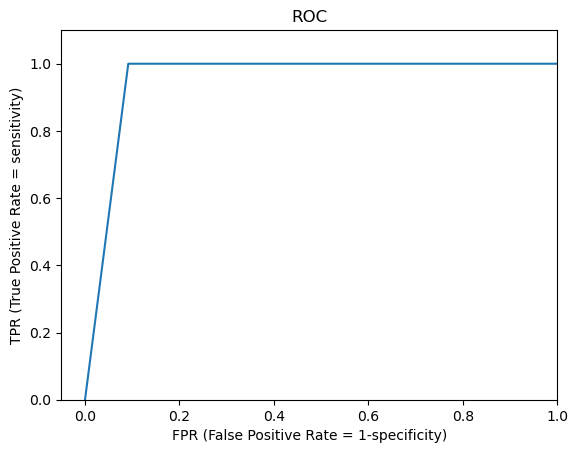

In [23]:
fpr, tpr, thresholds = roc_curve(y, XGB_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [25]:
XGB = XGBClassifier(n_estimators=700)
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    "over__sampling_strategy": [0.4,0.5,0.6],
    "over__k_neighbors": [7,9],
    "XGB__max_depth": [3,4,5],
    "XGB__scale_pos_weight": [10,50,80,90],
    'XGB__subsample': [0.8,1.0],
    "XGB__colsample_bytree": [0.8,1.0],
    "XGB__gamma":[ 2,3,5],
    "XGB__learning_rate":[0.05,0.01]
}

In [26]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(f_new2))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

Best parameter (CV score=1.280):
{'XGB__colsample_bytree': 0.8, 'XGB__gamma': 2, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__scale_pos_weight': 90, 'XGB__subsample': 1.0, 'over__k_neighbors': 9, 'over__sampling_strategy': 0.5}


In [27]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1:  0.294
Mean recall: 0.940
Mean precision: 0.174


(0.0, 1.1)

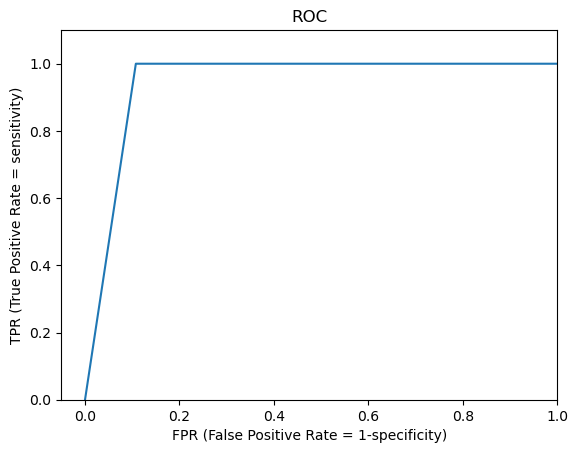

In [28]:
fpr, tpr, thresholds = roc_curve(y, XGB_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [29]:
print(report(XGB_search, X, y))

accuracy: 0.895

      0.0  1.0
0.0  3509  423
1.0     0   92

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      3932
         1.0       0.18      1.00      0.30        92

    accuracy                           0.89      4024
   macro avg       0.59      0.95      0.62      4024
weighted avg       0.98      0.89      0.93      4024



# lgbm

new

In [56]:
LGBM = LGBMClassifier()
LGBM_steps = [("scaler", scaler), ("over", over), ("LGBM", LGBM)]
pipe_LGBM = Pipeline(steps=LGBM_steps)

param_grid_LGBM = {
    "over__sampling_strategy": [0.1,0.2,0.3],
    "over__k_neighbors": [6,7,8],
    "LGBM__max_depth": [3,4,6,7,8],
    "LGBM__learning_rate":[0.05,0.1,0.2,0.01],
    "LGBM__class_weight":[{0: 1, 1: 10},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 5},{0: 1, 1: 6}],
     "LGBM__lambda_l1":[0,1]
}

In [58]:
LGBM_search = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring=make_scorer(f_new))
LGBM_search.fit(X, y)
LGBM_estimator =LGBM_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search.best_score_)
print(LGBM_search.best_params_)

Best parameter (CV score=1.133):
{'LGBM__class_weight': {0: 1, 1: 5}, 'LGBM__lambda_l1': 0, 'LGBM__learning_rate': 0.01, 'LGBM__max_depth': 4, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.1}


In [59]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(LGBM_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1:  0.315
Mean recall: 0.826
Mean precision: 0.195


old

In [21]:
LGBM_search = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring='f1')
LGBM_search.fit(X, y)
LGBM_estimator =LGBM_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search.best_score_)
print(LGBM_search.best_params_)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
Best parameter (CV score=0.404):
{'LGBM__class_weight': {0: 1, 1: 3}, 'LGBM__lambda_l1': 1, 'LGBM__learning_rate': 0.01, 'LGBM__max_depth': 7, 'over__k_neighbors': 7, 'over__sampling_strategy': 0.1}


In [22]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(LGBM_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1:  0.365
Mean recall: 0.485
Mean precision: 0.299


In [24]:
LGBM_search_recall = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring=make_scorer(f1_recall_avg))
LGBM_search_recall.fit(X, y)
LGBM_estimator_recall =LGBM_search_recall.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search_recall.best_score_)
print(LGBM_search_recall.best_params_)

Best parameter (CV score=0.446):
{'LGBM__class_weight': {0: 1, 1: 5}, 'LGBM__lambda_l1': 1, 'LGBM__learning_rate': 0.01, 'LGBM__max_depth': 6, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.1}


In [55]:
print("Best parameter (CV score=%0.3f):" % LGBM_search_recall.best_score_)

print(LGBM_search_recall.best_params_)

Best parameter (CV score=0.417):
{'LGBM__class_weight': {0: 1, 1: 5}, 'LGBM__lambda_l1': 1, 'LGBM__learning_rate': 0.05, 'LGBM__max_depth': 6, 'over__k_neighbors': 8, 'over__sampling_strategy': 0.1}


In [56]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores_recall = cross_validate(LGBM_estimator_recall, X, y, scoring=['recall','f1'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores_recall['test_f1']))
print('Mean recall: %.3f' % mean(scores_recall['test_recall']))

Mean f1:  0.358
Mean recall: 0.659


with 0.2 recall 

In [25]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores_recall = cross_validate(LGBM_estimator_recall, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
print('Mean f1:  %.3f' % mean(scores_recall['test_f1']))
print('Mean recall: %.3f' % mean(scores_recall['test_recall']))
print('Mean recall: %.3f' % mean(scores_recall['test_precision']))


Mean f1:  0.327
Mean recall: 0.718
Mean recall: 0.213


In [26]:
print("LGBM with f1 scorer:")
print(report(LGBM_search, X, y))

LGBM with f1 scorer:
accuracy: 0.946

      0.0  1.0
0.0  3724  208
1.0     9   83

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      3932
         1.0       0.29      0.90      0.43        92

    accuracy                           0.95      4024
   macro avg       0.64      0.92      0.70      4024
weighted avg       0.98      0.95      0.96      4024



In [61]:
print("LGBM with f1 and recall scorer:")
print(report(LGBM_search_recall, X, y))

LGBM with f1 and recall scorer:
accuracy: 0.962

      0.0  1.0
0.0  3780  152
1.0     1   91

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      3932
         1.0       0.37      0.99      0.54        92

    accuracy                           0.96      4024
   macro avg       0.69      0.98      0.76      4024
weighted avg       0.99      0.96      0.97      4024



In [64]:
LGBM_estimator_recall.named_steps['LGBM'].feature_importances_

array([171, 194,  15, 100, 118, 130,  29,  22, 173, 114,   4,   2,  25,
       225])

In [63]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, LGBM_search_recall.best_estimator_.named_steps['LGBM'].feature_importances_):
     print(i,round(f,2))

feature importances: 
Age 171
T Stage  194
N Stage 15
6th Stage 100
Grade 118
Tumor Size 130
Estrogen Status 29
Progesterone Status 22
Regional Node Examined 173
Reginol Node Positive 114
Race_Black 4
Race_Other 2
Race_White 25
Regional_Node_pos_% 225


In [26]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, LGBM_search_recall.best_estimator_.named_steps['LGBM'].feature_importances_):
     print(i,round(f,2))

feature importances: 
Age 99
T Stage  185
N Stage 14
6th Stage 100
Grade 142
Tumor Size 24
Estrogen Status 6
Progesterone Status 0
Regional Node Examined 110
Reginol Node Positive 106
Race_Black 0
Race_Other 0
Race_White 0
6th Stage_IIA 0
6th Stage_IIB 0
6th Stage_IIIA 0
6th Stage_IIIB 0
6th Stage_IIIC 0
Regional_Node_pos_% 245
Estrogen&Progesterone positive 0
Estrogen&Progesterone Negative 0


playing with the code